In [1]:
%reset -f

In [2]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import datetime as DT
import pandas as pd
import math
import scipy as sp
import datetime
from IPython.core.debugger import Tracer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.classification import log_loss

from sklearn import datasets, linear_model
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC, SVR
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest

%matplotlib inline
import seaborn as sns; sns.set()
import operator
import itertools
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr

import utils as ut
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Load in new data set and get an idea of dimensions
## 1) load data

In [5]:
def coltodatetime(df, col):
    df[col] = pd.to_datetime(df[col], infer_datetime_format=True)
def splitcol(df, col, char):
    df[col] =df[col].fillna('')
    r = df[col].apply(lambda x: pd.Series(x.split(char)))
    for i in range(0, r.shape[1]):
        df[col + str(i)] = r[i]
    #del df[col]
def combinedatentime(df, datecol, timecol, newcol):
    df[newcol] = df.apply(lambda row: datetime.datetime.combine(row[datecol].date(), row[timecol].time()), axis=1) 


In [20]:
#f1 = "C:/Users/lloyd/data/LFB incident data 1 Jan 2009 to 31 Aug 2015/LFB incident data 1 Jan 2009 to 31 Dec 2011.csv"
f1 = "/Users/david/data/historical_balance.csv"
f2 = "/Users/david/data/historical_direct_debits.csv"

df1 = pd.read_csv(f1, header=0, nrows = 10000000)
df2 = pd.read_csv(f2, header=0, nrows = 10000000)
coltodatetime(df1, "date")
coltodatetime(df2, "post_date")
coltodatetime(df2, "value_date")
df1['month'] = df1["date"].apply(lambda x : x.month)
df1['day'] = df1["date"].apply(lambda x : x.day)
df1['weekday'] = df1["date"].apply(lambda x : x.weekday())
df1['weeknum'] = df1["date"].dt.week
#df1['chg'] = df1['cleared_balance'] - df1['cleared_balance'].shift(1)

df1.sort(['account_num', 'date'], inplace=True)
df1['chg'] = df1['cleared_balance'].diff()
mask = df1.account_num != df1.account_num.shift(1)
df1['chg'][mask] = 0
#df1['dd_chg'] = 0

print("Dataframe shape")
print(df1.shape)
print(df2.shape)

print("Columns")
print(df1.dtypes)
print(df2.dtypes)
print("Samples")
ut.dispdf(df1,5)
ut.dispdf(df2,5)

Dataframe shape
(7546184, 9)
(991891, 8)
Columns
account_num                 int64
date               datetime64[ns]
ledger_balance            float64
cleared_balance           float64
month                       int64
day                         int64
weekday                     int64
weeknum                     int64
chg                       float64
dtype: object
account_num                    int64
post_date             datetime64[ns]
value_date            datetime64[ns]
description                   object
amount                       float64
country_code                  object
overseas_indicator            object
BACS_user_num                  int64
dtype: object
Samples


,account_num,date,ledger_balance,cleared_balance,month
1198147,283784177,2015-12-01,927.5,927.5,12
1198148,283784177,2015-12-02,817.0,817.0,12
1198149,283784177,2015-12-03,629.0,629.0,12
1198150,283784177,2015-12-04,619.0,619.0,12
1198151,283784177,2015-12-05,619.0,619.0,12
1198152,283784177,2015-12-06,619.0,619.0,12
1198153,283784177,2015-12-07,557.5,557.5,12
1198154,283784177,2015-12-08,514.5,514.5,12
1198155,283784177,2015-12-09,514.5,514.5,12


,day,weekday,weeknum,chg
1198147,1,1,49,0.0
1198148,2,2,49,-110.5
1198149,3,3,49,-188.0
1198150,4,4,49,-10.0
1198151,5,5,49,0.0
1198152,6,6,49,0.0
1198153,7,0,50,-61.5
1198154,8,1,50,-43.0
1198155,9,2,50,0.0


,account_num,post_date,value_date,description,amount
0,12207455809793,2015-12-15,2015-12-16,PAYPAL,8.0
1,12207455809793,2015-12-24,2015-12-29,HSBC,276.0
2,12207455809793,2015-12-30,2015-12-31,PAYPAL,26.0
3,12207455809793,2015-12-08,2015-12-09,PAYPAL,22.5
4,12207455809793,2015-12-22,2015-12-23,PAYPAL,17.5
5,12207455809793,2015-12-30,2015-12-31,PAYPAL,16.5
6,12207455809793,2015-12-31,2016-01-04,SANTANDER,80.0
7,12207455809793,2015-12-03,2015-12-04,PAYPAL,13.0


,country_code,overseas_indicator,BACS_user_num
0,GBP,N,679848
1,GBP,N,599938
2,GBP,N,679848
3,GBP,N,679848
4,GBP,N,679848
5,GBP,N,679848
6,GBP,N,880141
7,GBP,N,679848


## 2) figure out primary key

In [7]:
def isunique(df, col):
    return  len(df[col]) ==  len(set(df[col]))

In [8]:
#print("IsUnique ", isunique(df, "IncidentNumber"))

## 3) figure out what types of columns you have, numerical, categorical and nlp

In [9]:
def splitcoltypes(df):
    numcols = []
    datcols = []
    catcols = []
    for i in range(len(df.columns)):
        if(df.dtypes[i] == "object"):
            catcols.append(df.columns[i])
        elif(df.dtypes[i] == "datetime64[ns]"):
            datcols.append(df.columns[i])
        else:
            numcols.append(df.columns[i])
    return numcols, datcols, catcols

## 4) deal with numerical
- 4a) for each column, min, max, count, missing, types

In [10]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def colstats(df, c):
    vals = df[c]
    count = len(vals)
    min = np.min(vals)
    max = np.max(vals)
    per_25 = np.percentile(vals, 25)
    mean = np.mean(vals)
    mode = sp.stats.mode(vals)
    per_75 = np.percentile(vals, 75)
    std = np.std(vals)
    #expected 3
    kurt = sp.stats.kurtosis(vals)
    skew = sp.stats.skew(vals)
    nans = vals.isnull().sum()
    per_nans = nans/count * 100
    out_num = len(df[c][mad_based_outlier(df[c].values)])
    out_per = out_num/count * 100

    d = {"count": count, "min": min, "max": max, "per_25": per_25, "mean": mean,
         "per_75": per_75, "std": std, "kurt": kurt, "skew": skew, "nans": nans, 
         "nans_per": per_nans, "out_num": out_num, "out_per": out_per, "mode":mode
        }
    
    st = pd.DataFrame.from_dict(d, orient='index')
    st.rename(columns={0: c }, inplace=True)
    st.sort_index(inplace=True)
    return st

def coldatetimestats(df, c):
    vals = df[c]
    count = len(vals)
    min = np.min(vals)
    max = np.max(vals)
    nans = vals.isnull().sum()
    per_nans = nans/count * 100
    

    d = {"count": count, "min": min, "max": max,"nans": nans, 
         "nans_per": per_nans, 
        }
    
    st = pd.DataFrame.from_dict(d, orient='index')
    st.rename(columns={0: c }, inplace=True)
    st.sort_index(inplace=True)
    return st

def catstats(df, c):
    vc = df[c].value_counts()
    count = len(vc)

    d = {"catcount": count, 
        }
    
    st = pd.DataFrame.from_dict(d, orient='index')
    st.rename(columns={0: c }, inplace=True)
    st.sort_index(inplace=True)
    return st


def removenans(df, c):
    return df.dropna(subset=[c])

def dataframestats(df):
    stats = pd.DataFrame()
    for c in df.columns:
        if(not df[c].dtype == "object" and not df[c].dtype == "datetime64[ns]"):
            st = colstats(df, c)
            stats[c] = st[c]
    return stats

def dataframedatetimestats(df):
    stats = pd.DataFrame()
    for c in df.columns:
        if(df[c].dtype == "datetime64[ns]"):
            st = coldatetimestats(df, c)
            stats[c] = st[c]
    return stats


def dataframecatstats(df_local):
    stats = pd.DataFrame()
    for c in df_local.columns:
        if(not df_local[c].dtype == 'float64' and not df_local[c].dtype == 'int64'):
            print(df_local.shape)
            st = catstats(df_local, c)
            stats[c] = st[c]
    return stats

- 4b) shapes of distribution
- 4c) fill in missing values/drop them

In [11]:
#dist functions
def showdist(df, c, threshold=3.5):
    ut.figurefullwidth()
    nans = df[c].isnull().sum()
    vals = df[c].dropna().values
    ut.subplottitle(1, "Nans", w=6)
    plt.bar([1, 2], [len(df[c])-nans,nans], tick_label = ["Ok", "NaN"])
    ut.subplottitle(2, "Hist", w=6)
    plt.hist(vals, bins=20)
    ut.subplottitle(3, "Plot", w=6)
    plt.plot(vals, 'o')
    ut.subplottitle(4, "Box", w=6)
    sns.boxplot(vals)
    outliers = mad_based_outlier(df[c].values)
    outpoints = df[c][outliers]
    ut.subplottitle(5, "Distplot", w=6)
    sns.distplot(df[c], bins=20, hist=False)
    ut.subplottitle(6, "Outliers", w=6)
    plt.plot(outpoints, 'ro')
    out_per = (len(outpoints)/df.shape[0])*100
    nan_per = (nans/df.shape[0])*100
    print(c,df.shape,"Ouliers", len(outpoints), "{:1.2f}".format(out_per),"%","Nans",nans, "{:1.2f}".format(nan_per),"%","\n")
    plt.show()
    
def examineonenumcol(df, c):
    showdist(df, c)
    #df2 = removeoutliers(df, c)
    #chg = df2.shape[0] - df.shape[0]
    #chg_per = chg / df.shape[0] * 100.0
    #print(c, "After",df2.shape,chg, "{:10.2f}".format(chg_per) + "%", "\n")
    #showdist(df2, c)

def removeoutliers(df, c, threshold=3.5):
    outliers = mad_based_outlier(df[c].values)
    outpoints = df[c][outliers]
    return df.drop(outpoints.index)

def removeoutliersfromcols(df, cols, threshold=3.5):
    print("#===============================================")
    print("# Remove outliers from", cols)
    print("#===============================================")

    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2 = removeoutliers(df2, c)
    return df2

def removecols(df, cols):
    print("#===============================================")
    print("# Remove cols ", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2 = df2.drop(c, axis=1)
    return df2
def removenansfromcols(df, cols):
    print("#===============================================")
    print("# Remove nan from cols ", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            val_list = df2[df2[c].apply(lambda x: np.isnan(x))]
            print(len(val_list))
            df2 =df2.drop(val_list.index)
    return df2
def makenormalfromexp(df, cols):
    print("#===============================================")
    print("# make normal from exp", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2[c] = df2[c].apply(lambda x: 1/x)
    return df2
def makenormalfromlog(df, cols):
    print("#===============================================")
    print("# make normal from lognormal", cols)
    print("#===============================================")
    df2 = df.copy(deep=True)

    for c in cols:
        if(c in df2.columns):
            df2[c] = df2[c].apply(lambda x: np.log(x))
    return df2

## Main area for adding / removing columns and transforming data

In [12]:
def dispcatdata(df, c):
    vc = df[c].value_counts()
    print(c, " counttypes ",vc.shape[0],  "\n")
    if(vc.shape[0] > 100):
        print("Data is large!!!!!!!!!!!! " , vc.shape[0])
    cumsum = np.cumsum(vc.values)
    cumsum = cumsum/len(df[c])
    if False:
        ut.subplottitle(1, "CumSum")
        plt.plot(cumsum)
    #print(vc)
    ut.figurefullwidth()
    vc[:100].plot(kind='bar')
    plt.show()
    pro = 0;
    for n in vc.values:
        pro
    
def sigvals(df, c, threshold=0.8, num=0):
    print(df.columns, c)
    vc = df[c].value_counts()
    names = vc.index.tolist()
   
    count = len(df[c])
    cutoff = (int)(count * threshold)
    acc = 0
    num_acc = 0;
    ret = []
    others = []
    for i in range(vc.shape[0]):
        #print(names[i])
        if acc < cutoff and num_acc < num -1:
            ret.append(names[i])
        else:
            others.append(names[i])
        acc += vc[i]
        num_acc += 1
    return ret, others


def filteronsig(df, cols, threshold=0.8, num=0):
    df2 = df.copy(deep=True)
    for c in cols:
        #print(c)
        sig, others = sigvals(df2, c, threshold=threshold, num=num)
        df2[c] = df2[c].apply(lambda x: x if x in sig else "other")
    return df2

def examineonecatcol(df_local, c, threshold):
    df_temp = filteronsig(df_local, [c], threshold=threshold)
    diff = df_local.shape[0] - df_temp.shape[0]
    print(df_temp.shape, diff, "{:1.2f}".format(diff/df_local.shape[0]*100), "% elements in bottom ", "{:1.2f}".format((1-threshold)*100), "% of categories")
    dispcatdata(df_local, c)

In [21]:
#l1 = list(set(df2["account_num"]))
#len(l1)
#df1 = df1[df1["account_num"].isin(l1)]
#df1.shape

gb1 = df2.groupby(['account_num', 'value_date'])['amount'].sum()

dft1 = pd.DataFrame({'dd_chg' : gb1}).reset_index()
#dft1
df1["value_date"] = df1["date"]
df1 = pd.merge(df1, dft1, how="right",on=['account_num', 'value_date'])
#df1
stats = dataframedatetimestats(df1)
ut.dispdf(stats, 5, num=20)
#pd.set_option('display.max_rows', 300)

#for acc, vd in gb1.groupby(level=0):
#     print(acc, vd)
#gb1.xs(9612626356, level='account_num').xs("2015-12-03", level='value_date')
#gb1.loc['9612626356',"2015-12-03"]

#df1["dd_chg"] = df1.apply(lambda row: row["account_num"], axis=1)
#df1["dd_chg"] = df1.apply(lambda row: -gb1[row["account_num"]][row["date"]] if (row["account_num"] in gb1.index and row["date"] in gb1[row["account_num"]].index) else 0, axis=1)
df1["chgexdd"] = df1["chg"] - df1["dd_chg"]
debit = df1["chg"]<0
inoverdraft = df1["cleared_balance"]<0
df1["intodraft"] = df1.apply(lambda row: 1 if (row["chg"]<0 and row["cleared_balance"]<0 and row["dd_chg"] != 0 and (row["cleared_balance"]-row["chg"])>0) else 0, axis=1)
dft1 = df1[df1["dd_chg"] != 0]
dft1 = dft1.dropna()
print("intodraft")
print(dft1["intodraft"].sum())
print(len(dft1["intodraft"]))
#df1
#acc = 9612626356
#date = "2015-12-03"
#if(acc in gb1.index and date in gb1[acc].index):
#    print (gb1[acc][date])
#else:
#    print("not found")
#if 17590787337544 in gb1.index:
#    gb1[17590787337544]
gb2 = df1.groupby(['account_num'])['cleared_balance'].min()
#gb2[17590787337544]

#gb3 = df1[df1["account_num"]==4732336986].group
#gb3

#s1 = set(df1["account_num"])
#df3 = pd.DataFrame(list(s1), columns=["account_num"])
#df3["dd_num"] = df3["account_num"].apply(lambda a: gb1.get(a, 0))
#df3
#df1["dd_num"] = =

#dft3 = df1[debit & inoverdraft]
#dft3

#some dd 9612626356
#no dd 17590787337544

#stats = dataframestats(df3)
#ut.dispdf(stats, 5, num=20)
#examineonenumcol(df3, "dd_num")
#s.get('f', np.nan)
#pd.get_option('display.max_rows')
#dft1 = df1[df1["account_num"]==17590787337544]
#dft1
#dft2 = df2[df2["account_num"]==17590787337544]
#dft2

,date,value_date
count,649773,649773
max,2016-05-31 00:00:00,2016-06-01 00:00:00
min,2015-12-01 00:00:00,2015-12-01 00:00:00
nans,25243,0
nans_per,3.8849,0


intodraft
19931
624341


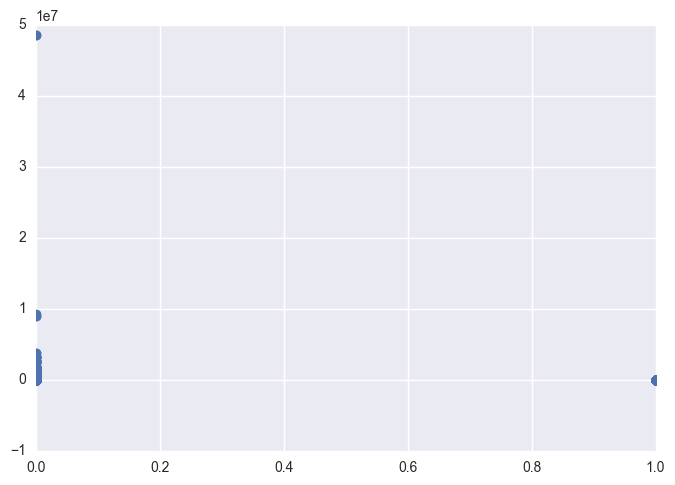

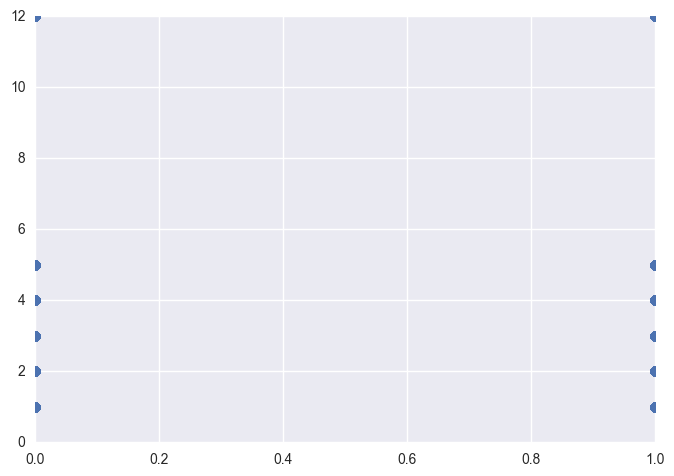

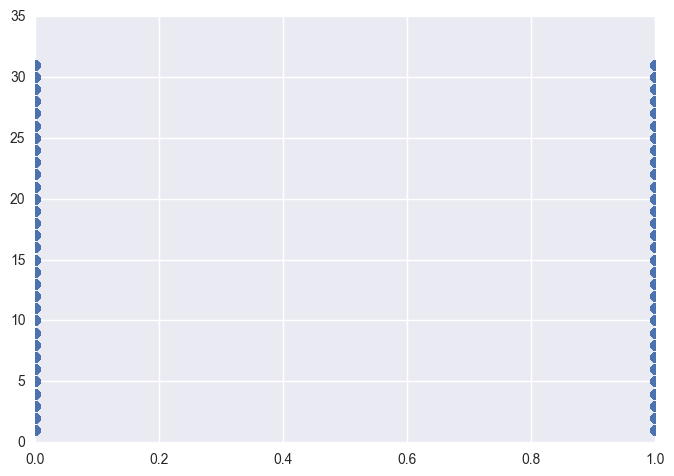

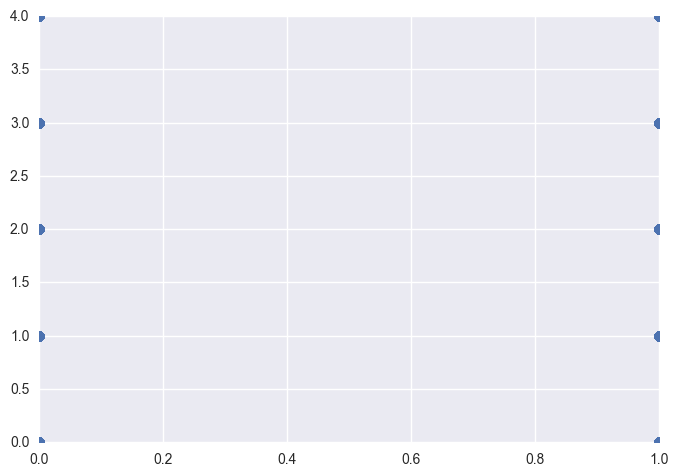

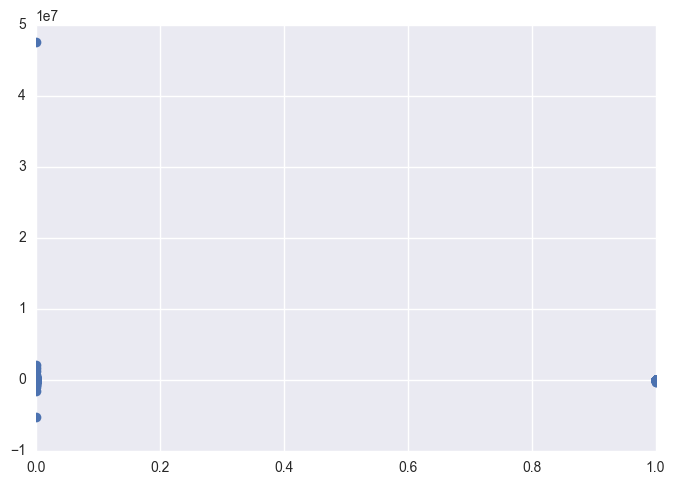

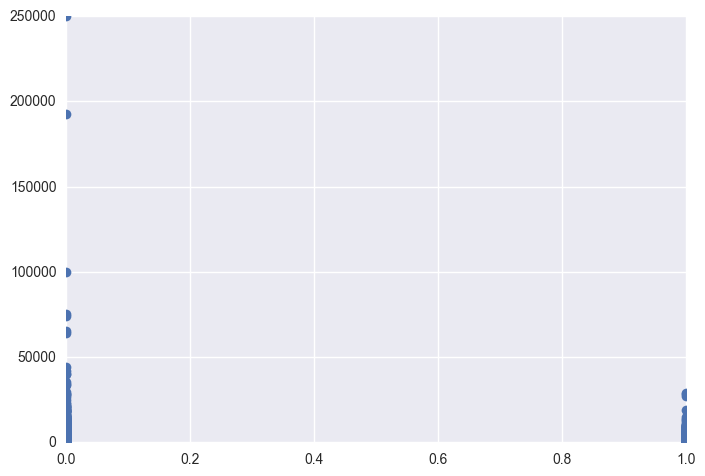

In [22]:
#cleared_balance	month	day	weekday	chg	dd_chg	chgexdd

plt.plot(dft1["intodraft"], dft1["cleared_balance"], 'o')
plt.show()
plt.figure()
plt.plot(dft1["intodraft"], dft1["month"], 'o')
plt.show()
plt.figure()
plt.plot(dft1["intodraft"], dft1["day"], 'o')
plt.show()
plt.figure()
plt.plot(dft1["intodraft"], dft1["weekday"], 'o')
plt.show()
plt.figure()
plt.plot(dft1["intodraft"], dft1["chg"], 'o')
plt.show()
plt.figure()
plt.plot(dft1["intodraft"], dft1["dd_chg"], 'o')
plt.show()

In [ ]:
numcols, datcols, catcols = splitcoltypes(df)
print("Numerical Columns", len(numcols))
print(numcols, "\n")
print("Datetime Columns", len(datcols))
print(datcols, "\n")
print("Categorical Columns", len(catcols))
print(catcols, "\n")

In [ ]:
onehotencodings = {}
def onehotencode(df, cols):
    for c in cols:
        if(c in df.columns):
            pre_cols = df.columns
            temp_col = df[c]
            df = pd.get_dummies(df, columns=[c])
            df[c] = temp_col
            post_cols = df.columns
            diff_cols = list(set(post_cols) - set(pre_cols))
            onehotencodings[c] = diff_cols
    return df
   
#dummyencodings = {}
#def dummyencode(df2, col):
#    if(df2[c].dtype == "object"):
#        le = LabelEncoder()
#        df2[c] = df2[c].apply(lambda x: 'NaN' if pd.isnull(x) else x)
#        df2[c] = le.fit_transform(df2[c])
#        encodings[c] = le
#    return df

def encodecols(df, catcols, dummy=False):
    df2 = df.copy(deep=True)
#    if(dummy):
#        for c in catcols:
#            if(c in df2.columns):
#                df2 = dummyencode(df2, c)
#    else:
    df2 = onehotencode(df2, catcols)
    return df2

def printencodings(catcols):
    tenc1 = pd.DataFrame()
    for c in catcols:
        if(c in onehotencodings):
            classes = onehotencodings[c]
            tenc = pd.DataFrame(classes, index = range(len(classes)))
            tenc[c] = tenc[0]
            del tenc[0]
            ut.dispdf(tenc, num=10)


In [ ]:
df_temp = df
print("Numerical columns")
print (numcols)
print("Categorical columns")
print (catcols)
outcols = []
remcols = []
nancols =  []
logcols = []
filtcols = []
    
if(False):
    outcols = []
    remcols = []
    nancols =  []
    logcols = []

# After examination of dataset
#===============================================
# 1) Remove certain value, Nans 
#===============================================
df_temp = removenansfromcols(df_temp,nancols)
#===============================================
# 2) make cols normal through ln
#===============================================
df_temp = makenormalfromlog(df_temp, logcols)
#===============================================
# 3) Remove outliers on cols
#===============================================
df_temp = removeoutliersfromcols(df_temp, outcols)
#===============================================
# 4) Remove cols that don't matter
#===============================================
df_temp = removecols(df_temp, remcols)
#===============================================
# 5) Filter cols with large cat number
#===============================================
df_temp = filteronsig(df_temp,filtcols, num=20)
 
#===============================================
# Examine the dataset
#===============================================
ignorecols = []
#ignorecols = ['IncidentNumber', 'Easting_m','Northing_m','Easting_rounded','Northing_rounded']
len(numcols)
stats = dataframestats(df_temp)
ut.dispdf(stats, 5, num=20)


#Skip/Include examine of numericals
if(True):
    for c in numcols:
        if(c not in ignorecols and c in df_temp.columns):
            examineonenumcol(df_temp, c)
        
threshold = 0.8
print(df_temp.shape)
cstats = dataframecatstats(df_temp)
ut.dispdf(cstats, 5, num=20)
if(True):
    for c in catcols:
        if(c not in ignorecols and c in df_temp.columns):
            examineonecatcol(df_temp, c, threshold)

#===============================================
# 6) ASSIGN it back to df - when you are happy with it!!!!!
#===============================================
if(True):
    print("#===============================================")
    print("# ONE HOT ENCODING ")
    print("#===============================================")
    #do the one hot encoding
    print(catcols)
    print(df_temp.shape)
    df_temp = encodecols(df_temp, catcols)

    df_orig = df
    df = df_temp
    df = df.reset_index(drop=True)
    numcols, datcols, catcols = splitcoltypes(df)
    print("#===============================================")
    print("# COMPLETE DATA CLEAN FOR df ")
    print("#===============================================")

#print("#===============================================")
#print("# AFTER TRANSFORM")
#print("#===============================================")


## 5) deal with categorical
- 5a) for each col count values
- 5b) fill in missing values/drop them

## 6) nlp -> look but dont touch

## 6) Finally remove the columns that dont' matter to get final dataset we can work on clealy

## 7) Nice clean data set we can do something to

## 7a) do a big old linear regression map and them iso map it

In [ ]:
def plot_matrix(cm, classesx, classesy,
                          normalize=True,
                          title='matrix',
                          cmap=plt.cm.Blues,
                          axis=0):
   
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marksx = np.arange(len(classesx))
    plt.xticks(tick_marksx, classesx, rotation=90)
    tick_marksy = np.arange(len(classesy))
    plt.yticks(tick_marksy, classesy)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.grid(False) 
    #for axi in (ax.xaxis, ax.yaxis):
    #    for tic in axi.get_major_ticks():
    #        tic.tick1On = tic.tick2On = True
    #        tic.label1On = tic.label2On = False
    orig = cm
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=axis)
    thresh = (cm.max() - cm.min()) * 0.5 + cm.min()
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        s = "{:1.2f}".format(cm[i,j])
        #s = "{:1.4f}".format(cm[i,j]) + "("+str(orig[i,j])+")"
        plt.text(j, i, s, horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('Y label')
    plt.xlabel('X label')

def onelr(x1, y1):
    lr = LinearRegression()
    lr.fit(x1, y1)
    
    return lr.score(x1, y1)

def plotcorrel(df_temp, colsx, colsy):
    num_coef = np.empty((len(colsx),len(colsy),))
    num_coef[:] = np.NAN
    x_labels = []
    y_labels = []
    for i in range(len(colsx)):
        c_i = colsx[i]
        if(c_i in df_temp.columns):
            df_temp = df_temp.dropna(subset=[c_i])
            y_labels.append(c_i + "("+str(df_temp.shape[0])+")")
            #print(c_i, df_temp.shape)
            for j in range(len(colsy)):
                c_j = colsy[j]
                if len(x_labels)  < len(colsy):
                     x_labels.append(c_j + "("+str(df_temp.shape[0])+")")
                if(c_j in df_temp.columns):
                    df_temp = df_temp.dropna(subset=[c_j])
                    vals_i = df_temp[c_i].values.reshape(-1,1)
                    vals_j = df_temp[c_j].values.reshape(-1,1)
                    if(np.isnan(vals_j).sum() == 0):
                        #r = onelr(vals_i, vals_j)
                        pcor = sp.stats.pearsonr(vals_i, vals_j)
                        #print(pcor)
                        num_coef[i, j] = pcor[0][0]
    #print(num_coef)
    ut.figurefullwidth()
    plot_matrix(num_coef, x_labels, y_labels, normalize=False, title="")

In [ ]:
numcolsexOH = numcols
for key in onehotencodings.keys():
    numcolsexOH = list(set(numcolsexOH) - set(onehotencodings[key]))
print(numcolsexOH)
plotcorrel(df, numcolsexOH, numcolsexOH)
plt.figure()
#plt.plot(df["NumStationsWithPumpsAttending"], df["NumPumpsAttending"], 'o')
#plt.show()

In [ ]:
 
def plot_catmatrix(cm, x_labels, y_labels,
                          normalize=False,
                          title='matrix',
                          cmap=plt.cm.Blues,
                          y_title="", x_title="",
                          axis=0):
   
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(x_labels))
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90)
    plt.yticks(np.arange(len(y_labels)), y_labels)
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    ax.grid(False) 
    #for axi in (ax.xaxis, ax.yaxis):
    #    for tic in axi.get_major_ticks():
    #        tic.tick1On = tic.tick2On = True
    #        tic.label1On = tic.label2On = False
    orig = cm
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=axis)
    thresh = (cm.max() - cm.min()) * 0.5 + cm.min()
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        v = cm[i,j]
        if(np.isnan(v)):
            s = '-'
        else:
            s = "{:1.2f}".format(v)
        #s = "{:1.4f}".format(cm[i,j]) + "("+str(orig[i,j])+")"
        plt.text(j, i, s, horizontalalignment="center",fontsize=8,
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.show()

def vc(df, c1, num=30):
    vc1 = df[c1].value_counts()
    n1 = vc1.index.tolist()
    
    if(len(n1) > num):
        df_temp = filteronsig(df, [c1], num=num)
        vc1 = df_temp[c1].value_counts()
        n1 = vc1.index.tolist()
    return vc1, n1


            
def plotcols(df, c1, c2):
    print(c1, c2)
    if(c1 in df.columns):
        vc1, n1 = vc(df, c1)
    else:
        return
    if(c2 in df.columns):
        vc2, n2 = vc(df, c2)
    else:
        return
    
    counts = np.empty((len(n1),len(n2),))
    counts[:] = np.NAN
    #print(vc2)
    for i in range(len(n1)):
        for j in range(len(n2)):
            if(c1 in df.columns and c2 in df.columns):
                c = len(df[(df[c1]==n1[i]) & (df[c2]==n2[j])])
                #print(c)
                counts[i,j] = c
    #print(counts)
    plot_catmatrix(np.transpose(counts), n1, n2, normalize=True, y_title=c2, x_title=c1)
    #x = LabelEncoder().fit_transform(df[c1])
    #y = LabelEncoder().fit_transform(df[c2])
    #plt.plot(x, y, 'o')
    #plt.show()
len(catcols)
#print(df.head())
print(catcols)
for c in catcols:
    plotcols(df, catcols[0], c)
#plotcols(df, catcols[0], catcols[4])


In [ ]:


for i in catcols:
    ohlist = onehotencodings[i]
    print(i)
    #print(ohlist)
    #print(df_temp.shape)
    ut.figurefullwidth()
    plotcorrel(df_temp, ohlist, ["FirstPumpArriving_AttendanceTime"])
    plt.show()



#print(df2.head())

## Plot categories vs 1 numberical

In [ ]:
def boxplotcats(df, c2, catcols=catcols):
    for c in catcols:
        if(len(onehotencodings[c]) < 100):
            #df_sub = inverseonehotencode(df, c,onehotencodings[c])
            _ = sns.boxplot(x=c, y=c2, data=df)
            _ = plt.xticks(rotation=90)
            plt.show()

def inverseonehotencode(df, col, cols):
    df2 = df.copy(deep=True)
    x = df2[cols].stack()
    s = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))
    df2[col] = s
    df2 = df2.drop(cols, axis=1)
    #print(s)
    return df2

#print(df.head())
#print(inverseonehotencode(df, catcols[0],onehotencodings[catcols[0]]).head())
#shall I do a clustering on the pump arrival times? 
#arrival times vs station?
c2 = "FirstPumpArriving_AttendanceTime"

from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

#t test means of data across category
for c in catcols:
    try:
        print(c2, c)
        p_vals = []
        labels = []
        sub_values = []
        for c_sub1 in onehotencodings[c]:
            sub_values.append(list(df[df[c_sub1] == 1][c2].values))
        #print(sub_values)
        #print(sub_values)
        #ANOVA test 1 way
        stat, pval = sp.stats.f_oneway(*sub_values)
        print("ANOVA", stat, pval)
        #df_sub = inverseonehotencode(df, c, onehotencodings[c])
        #print(df_sub[c].head())
        #print(df_sub[c2].head())
        mod = MultiComparison(df[c2], df[c])
        tukey = mod.tukeyhsd()
        print(mod.groupsunique)
        #print()
        #print(tukey.meandiffs)
        print (tukey)
        combs = list(itertools.combinations(mod.groupsunique, 2))
        #print(len(combs))
        ave_means = [];
        for d in mod.groupsunique:
            #print(d)
            sum_means = 0;
            count_means = 0;
            for i in range(len(combs)):
                #print(d, i)
                a, b = combs[i]
                if(a == d or b == d):
                    sum_means += tukey.meandiffs[i]
                    count_means += 1
            ave_means.append(sum_means/count_means)
        #print(ave_means, np.arange(len(mod.groupsunique)))
        _ = plt.bar(np.arange(len(mod.groupsunique)), ave_means, align='center')
        _ = plt.xticks(np.arange(len(mod.groupsunique)), mod.groupsunique)
        _ = plt.xticks(rotation=90)
        _ = plt.show()
        boxplotcats(df, c2, catcols=[c])
       
    except Exception as e: 
        print (str(e))
    #for c_sub1 in onehotencodings[c]:
    #    sub1 = df[df[c_sub1] == 1][c2].values
    #    sub1_not = df[df[c_sub1] == 0][c2].values
    #    #Welch's t-test
    #    _, p_val = sp.stats.ttest_ind(sub1, sub1_not, equal_var = False)
    #    sig = p_val < 0.05
    #    p_vals.append(p_val)
    #    labels.append(c_sub1)
    #    print(c_sub1, "{:1.4f}".format(p_val), "Sig=", sig, "sub1mean=", sub1.mean(), "sub2mean=", sub1_not.mean())
    #plot_catmatrix(np.matrix([p_vals]), labels, [c2], normalize=False, y_title=c2, x_title=c)




## Plot 2 numerical - not used

In [ ]:
def plot2numerical(df_temp, c1, c2):
    x = df_temp[c1]
    y = df_temp[c2]
    # fit with np.polyfit
    m, b = np.polyfit(x, y, 1)

    plt.figure()
    plt.plot(x, y, '.')
    plt.plot(x, m*x + b, '-')
    plt.xlabel(c1)
    plt.ylabel(c2)
    plt.show()

for c in numcolsexOH:
    plot2numerical(df_temp, c2, c)

## Plot categories vs 2 numerical - not used

In [ ]:
#hour vs pump arrival time
# for each category in BoroughName
c2 = "FirstPumpArriving_AttendanceTime"
c1 = "weekday"
c3 = "IncGeo_BoroughName"
print(onehotencodings)
for c in onehotencodings[c3]:
    #print(c)
    df_temp2 = df_temp[df_temp[c].apply(lambda x: x == 1)]
    plot2numerical(df_temp2, c1, c2)

## Now do a random forest to see what affects dependent var 

In [ ]:
def mse(pred, act):
    diff = np.mean(np.power(pred-act, 2))
    return diff

def oneRF(df, c_xs, c_y):
    #print(c_xs, c_y)
    x1 = df[c_xs].values
    y1 = df[c_y].values.reshape(-1, 1)
    #print(x1)
    #print(y1)
    #normalise the data
    scaler = StandardScaler()
    x1 = scaler.fit_transform(x1)
    #x2 = scaler.transform(x2)
    sv = RandomForestRegressor()
    
    estimators = []
    estimators.append(("RF", sv))
    model = Pipeline(estimators)
    param_rf = {"RF__max_depth": [3],
              #"RF__max_features": [1, 3],
              "RF__min_samples_split": [ 3],
              "RF__min_samples_leaf": [3],
              "RF__bootstrap": [True, False],
               }
    
    cv_splits = 2
   
   
    svm = GridSearchCV(model, cv=cv_splits, param_grid=param_rf)
    svm.fit(x1, y1)
    y1_pred = svm.predict(x1)
    s_in = mse(y1_pred, np.squeeze(y1))
    #s_out = svm.score(x2, y2)
    return s_in

In [ ]:
c2 = "FirstPumpArriving_AttendanceTime"
#finding the best predictor of c2

iteration = 0
colsleft = numcols
colsincluded = []
total_mse = []
iteration_list = [];
#picker doesn't quite seem to be doing as good a job as all columns
while(iteration < 160):
    res_list = []
    if(len(colsleft) == 0):
        break
    print("iteration", iteration)
    print("colsleft", len(colsleft))
    acc = 0;
    for c in colsleft:
        if(not c == c2):
            temp_cols = colsincluded + [c]
            #print(temp_cols)
            s_in = oneRF(df, temp_cols, c2)
            res_list.append({"col": c, "s_in": s_in})
            acc +=1
            print("("+str(acc)+")", s_in, end="")

    res = pd.DataFrame(res_list)
    res = res.sort_values(["s_in"])
    #res = res.reindex(range(0, len(res)))
    print(res.head())
    #---------------------------------------
    # select best k columns
    #---------------------------------------
    for i in range(20):
        if(len(res) > 0):
            bestcol = res["col"].iloc[0]
            print("BEST COLUMN ", bestcol)
            res = res.drop(res.index[0])
            colsincluded.append(bestcol)
    
    s_cur = oneRF(df, colsincluded, c2)
    iteration_list.append(iteration)
    total_mse.append(s_cur)
    
    colsleft = res["col"].values
    iteration+=1

In [ ]:
print("Fit benchmark of all columns")
#calc with all columns in it
numcolsexc2 = list(set(numcols)- set([c2]))
s_in_max = oneRF(df, numcolsexc2, c2)
horiz_line_data = [iteration_list[0], iteration_list[-1]]
plt.plot( horiz_line_data,[s_in_max, s_in_max], 'r') 

plt.plot(iteration_list, total_mse)
print(len(numcols), s_in_max)
print(len(colsincluded), total_mse[-1])
plt.show()

#might not use this function
def dorandtes():    
    randtests = 10
    randdf = pd.DataFrame(np.random.randint(0,100,size=(df.shape[0], randtests)))
    randdf[c2] = df[c2]
    print(randdf.head())
    randlist = []
    for c in randdf.columns:
        s_in = oneRF(randdf, [c], c2)
        randlist.append(s_in)

    mean = np.mean(randlist)
    std = np.std(randlist)
    up_limit = mean + 2* std
    low_limit = mean - 2* std
    res_list.append({"col": "up_rand", "s_in": up_limit})
    res_list.append({"col": "mean_rand", "s_in": mean})
    res_list.append({"col": "low_rand", "s_in": low_limit})
    

# Presentation
-------
1. General thoughts on the dataset
2. Specific question
* Is BLM charging the right amount vs man hours?
3. What data do we have to answer that question?
4. What data we use? high correlation
5. LR of man hours vs charge
6 Look at LR with groupings of different case types


In [ ]:
print(len(numcols), s_in_max)
print(len(colsincluded), total_mse[-1])
s_in_max = oneRF(df, numcols, c2)
horiz_line_data = [iteration_list[0], iteration_list[-1]]
plt.plot( horiz_line_data,[s_in_max, s_in_max], 'r') 

plt.plot(iteration_list, total_mse)
plt.show()